In [1]:
from IPython.display import display, HTML, display_html, Latex
import scipy
import pandas as pd
import numpy as np
from numpy import array, exp, zeros, sqrt, cos, sin, pi
from numpy.linalg import norm, inv
from scipy.special import ellipj, ellipk
from matplotlib import pyplot as plt

def npPrint(a, f={'float_kind': lambda x: "%.5e" % x}): # defining common functions from quiz
    print(np.array2string(a, formatter=f))


def forwardEuler(f, Df, t0, y0, h): 
    return y0 + h * f(t0, y0)


def Q11( f,Df, t0,y0, h):
    f0 = f(t0,y0)
    f1 = f(t0+h, y0+h*f0)
    return y0 + h/2*(f0+f1)


def crankNicholson(f, Df, t0, y0, h):
    m = len(y0)
    F = lambda x: x - ((1/2) * (f(t0, y0) + f(t0+h, y0+h*x)))
    DF = lambda x: np.eye(m) - ((1/2) * h * Df(t0+h, y0+h*x))
    x, k = newton(F, DF, f(t0+h, y0), h**2*1e-5,1000)
    y = y0 + h*x
    return y

def backwardEuler(f, Df, t0, y0, h):
    m = len(y0)
    F = lambda y: y - f(t0+h, y0 + h*y)
    DF = lambda y: np.eye(m) - h*Df(t0+h, y0 +h*y)
    y, _ = newton(F, DF, f(t0+h, y0),h*h*1e-5, 1000)
    return y0+h*y


def semiImplicitEuler(dV, t0,y0, h):
    xnew  = y0[0] + h*y0[1]
    pnew  = y0[1] - h*dV(xnew)
    return array([xnew,pnew])


def evolve(phi, f, Df, t0, y0, T, N):
    h = T / N
    n = np.arange(0, N + 1, 1)
    t = h * n
    y = np.zeros((N + 1, len(y0)))
    y[0] = y0
    for n in range(N):
        y[n + 1] = phi(f, Df, t[n], y[n], h)
    return t, y


def computeEocs(herr):
    eocs = np.zeros(0)
    h = herr[:, 0]
    e = herr[:, 1]
    i = 0
    while i < np.size(herr, 0) - 1:
        eocs = np.append(eocs, np.log(e[i + 1] / e[i]) / np.log(h[i + 1] / h[i]))
        i += 1
    return eocs


def newton(F, DF, x0, eps, K):
    x = x0
    k = 0
    while k < K:
        dx = np.linalg.solve(DF(x),-F(x))
        x += dx
        k += 1
        if np.linalg.norm(F(x)) < eps:
            break
    return x, k


def fullyImplicit( V,dV, t0,y0, h):
    x = y0[0]
    p = y0[1]
    F  = lambda xnew: array([xnew[0] - x - h*p + h**2/2 * (V(xnew[0]) - V(x)) / (xnew[0] - x)])
    DF = lambda xnew: array([[1                + h**2/2 * (dV(xnew[0])*(xnew[0]-x) - (V(xnew[0])-V(x)))/(xnew[0]-x)**2]])
    x0 = x+h*p-h**2/2*dV(x)
    xnew,n = newton(F,DF,array([x0]),1e-5*h*h,1000)
    assert n < 1000
    pnew = p - h * ( V(xnew[0]) - V(x) ) / (xnew[0] - x)
    return array([xnew[0],pnew])


def newtonScalar(F, DF, x0, eps, K):  # for scalar fully implciit method
    x = x0
    k = 0
    while k < K:
        dx = F(x)/DF(x)
        x -= dx
        k += 1
        if np.linalg.norm(F(x)) < eps:
            break
    return x, k


def dirk(f,Df, t0,y0, h, alpha,beta,gamma):
    m, s = len(y0), len(gamma)
    y = y0.copy().astype(float)
    k = np.zeros([s,m])
    for i in range(s):
        ti = t0+alpha[i]*h
        yi = y0.copy().astype(float)
        for j in range(i):
            yi += h*beta[i,j]*k[j]
        k[i,:] = f(ti,yi);
        if not beta[i,i] == 0:
            k[i,:],K = newton (lambda k: k-f(ti,yi+h*beta[i,i]*k),
                               lambda k: np.eye(m)-h*beta[i,i]*Df(ti,yi+h*beta[i,i]*k),
                               k[i,:], h*h*1e-5, 1000)
            assert K < 1000
        y += h*gamma[i]*k[i,:]
    assert( not np.any(np.isnan(y)) )
    return y





def taylor(f,Df,dtdf, t0,y0, h):
    y1 = f(t0,y0)
    y2 = Df(t0,y0).dot(y1) + dtdf(t0,y0)
    return y0 + h*y1 + (h**2/2)*y2


def expfitBackwardEuler(M,h):
    alpha, beta, gamma = 1,1,1
    exphMs    = scipy.linalg.expm(alpha*h*M)
    exphMsInv = inv(exphMs)
    exphM     = scipy.linalg.expm(h*M)
    def stepper(f,Df,t0,y0,h):
        # the actual ODE has right hand side f(t,y)-My
        fM  = lambda t,y: f(t,y) - M.dot(y)
        DfM = lambda t,y: Df(t,y) - M
        # explicit step - can be used as initial guess for Newton if beta_ii not equal to zero
        # if beta_ii = 0 then this is already the full stage
        k1 = exphMsInv.dot( fM( t0+alpha*h, exphMs.dot(y0) ) )
        F  = lambda k: k - exphMsInv.dot( fM(t0+alpha*h, exphMs.dot(y0 + h*beta*k)) )
        DF = lambda k: ( np.eye(len(y0)) - 
                         h*beta*DfM(t0+alpha*h,exphMs.dot(y0 + h*beta*k) ) )
        k1,n = newton(F,DF, k1, h*h*1e-5,1000)
        assert n < 1000
        return exphM.dot( y0 + h*k1 )
    return stepper


def experiment(stepper,f,Df,T,Y,M,N0):
    herr = zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        try:
            t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
            herr[m] = [T/N, max( norm(Y(t).transpose()-y,axis=1) )]
        except ValueError: # method not stable for given 'h'
            print("Error:", stepper,N,T/N,"failed: some NaN value produced!")
            herr[m] = [T/N, np.nan]
        except AssertionError: # assert in dirk was triggered (failed Newton)
            print("Error:", stepper,N,T/N,"failed: Newton function failed!")
            herr[m] = [T/N, np.nan]

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    return res




def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-error', f'{n}-eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.ylim([None, 10]) # Added in case some method really messes up so that one can still see the good ones
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()

    
def testHamiltonian(d):
    y0 = np.array([0,1])
    k = 0.8
    
    H  = lambda y: 0.5*y[1]**2 - np.cos(y[0])*omega0**2
    # and the resulting flow
    
    def f(t,y):
        return np.array([y[1], -np.sin(y[0])*(omega0**2)])


    def Df(t,y):
        return np.array([[0,1],[-np.cos(y[0])*(omega0**2),0]])
    # define 'M' for the exponentially fit methods:
    M = array([ [0,1], [-1, 0] ])
    # split steppers based on 'V'
    siStepper = lambda f,Df,t0,y0,h: semiImplicitEuler(dV,t0,y0,h)
    fiStepper = lambda f,Df,t0,y0,h: fullyImplicit(V,dV,t0,y0,h)

    def HamiltonianExperiment(stepper, f,Df,T,y0, H, N, name, ax1=None, ax2=None):
        try:
            t,y  = evolve(stepper,     f,Df,0,y0,T,N)
            H0 = H(y0)
            Herror = [abs(H(yn)-H0)/abs(H0) for yn in y]
            exact = Y(t).transpose()
            error = max( norm( y-exact, axis=1) )
            if ax1 is not None:
                ax1.semilogy(t,Herror,marker='o',label=name)
            if ax2 is not None:
                ax2.plot( y[:,0],  y[:,1], label=name )
        except ValueError: # method not stable for given 'h'
            print(name,N,T/N,"failed: some NaN value produced!")
            y,error = [], np.nan # return 'not a number' for the error
        except AssertionError: # assert in dirk was triggered (failed Newton)
            print(name,N,T/N,"failed: Newton function failed!")
            y,error = [], np.nan # return 'not a number' for the error
        return error

    # dictionary with label as keys and (stepper,error-vector) as values
    T = 40
    res = {"d = 1/4":[dirkQu,[]],
           "d = 1/2+rt(3)/6": [dirkRt,[]],           
          }
    for i in range(0,11):
        N = 150 * 2**i
        if i == 1 or i == 3:
            fig1, ax1 = plt.subplots()
            fig2, ax2 = plt.subplots()
        else:
            ax1, ax2 = None, None
        for i,name in enumerate(res.keys()):
            if i<5: # 'classic' steppers
                stepper = res[name][0]
            else: # not really a nice way of doing this
                stepper = res[name][0](M,T/N)
            err = HamiltonianExperiment(stepper, f,Df,T,y0, H, N,
                                        name,    ax1, ax2)
            res[name][1] += [ [T/N, err] ]
        if ax1 is not None:
            ax1.legend()
            ax1.grid(True)
            ax1.set_xlabel("time")
            ax1.set_ylabel("relative error in Hamiltonian")
            ax1.set_ylim([None, 100])

    fig = plt.figure()
    for k in res.keys():
        eoc = computeEocs( np.array(res[k][1]) )
        eoc = np.hstack( [ [np.nan],eoc ] )
        res[k] = np.hstack( [np.array(res[k][1]), np.atleast_2d(eoc).T] )
    return res

In [2]:
T = 10
Y = lambda t: array([ 2*exp(t)/(2*exp(t)-1),
                      (-2*exp(t))/(4*exp(2*t)-4*exp(t)+1) ])


def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])


def Df(t,y):
    return array([[0,1],[-2*y[1],1-2*y[0]]])

,h,d=0-error,d=0-eoc,d=1/4-error,d=1/4-eoc,d=1/2+rt(3)/6-error,d=1/2+rt(3)/6-eoc
0,4.0000e-01,2.336009e-01,nan,1.980480e-02,nan,4.445094e-02,nan
1,2.0000e-01,5.724377e-02,2.029,5.230983e-03,1.921,8.023322e-03,2.470
2,1.0000e-01,1.252991e-02,2.192,1.295326e-03,2.014,1.206827e-03,2.733
3,5.0000e-02,2.894328e-03,2.114,3.279166e-04,1.982,1.694120e-04,2.833
4,2.5000e-02,6.889803e-04,2.071,8.193583e-05,2.001,2.265019e-05,2.903
5,1.2500e-02,1.680073e-04,2.036,2.048125e-05,2.000,2.928069e-06,2.952
6,6.2500e-03,4.148271e-05,2.018,5.120441e-06,2.000,3.724442e-07,2.975
7,3.1250e-03,1.030578e-05,2.009,1.280133e-06,2.000,4.696281e-08,2.987
8,1.5625e-03,2.568356e-06,2.005,3.200340e-07,2.000,5.896118e-09,2.994
9,7.8125e-04,6.410798e-07,2.002,8.000879e-08,2.000,7.386347e-10,2.997


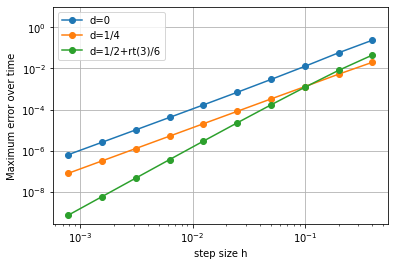

In [3]:
alpha = lambda d: np.array([d,1-d])
beta = lambda d: np.array([[d,0], [1-2*d,d]])
gamma = np.array([1/2,1/2])

def dirkD(d):
    return lambda f, Df, t0, y0, h: dirk(f, Df, t0, y0, h, alpha(d), beta(d), gamma)

dirk0 = dirkD(0)
dirkQu = dirkD(1/4)
dirkRt = dirkD((1/2)+(np.sqrt(3)/6))


res = {}
res["d=0"]             = experiment(dirk0,   f,Df,T,Y, M=10,N0=25)
res["d=1/4"]           = experiment(dirkQu,  f,Df,T,Y, M=10,N0=25)
res["d=1/2+rt(3)/6"]   = experiment(dirkRt,  f,Df,T,Y, M=10,N0=25)
compareErrors(res)

The consistency orders for d = 0 and 1/4 were both 2. However, the consistency order for 1/2 + rt(3)/6 is 3. The EOCs appear to agree with this as the first two d values have EOCs converging to 2 and the third has an EOC converging to 3.

,h,d=1/4-error,d=1/4-eoc,d=1/2+rt(3)/6-error,d=1/2+rt(3)/6-eoc
0,2.0000e-01,1.251875e+00,nan,6.537392e-01,nan
1,1.0000e-01,7.578248e-01,0.724,5.406771e-01,0.274
2,5.0000e-02,2.055127e-01,1.883,1.549727e-01,1.803
3,2.5000e-02,5.162034e-02,1.993,2.411841e-02,2.684
4,1.2500e-02,1.292101e-02,1.998,3.176290e-03,2.925
5,6.2500e-03,3.230647e-03,2.000,4.037491e-04,2.976
6,3.1250e-03,8.076769e-04,2.000,5.081911e-05,2.990
7,1.5625e-03,2.019200e-04,2.000,6.373193e-06,2.995


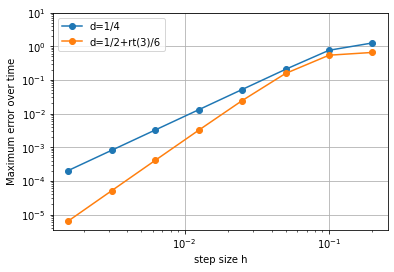

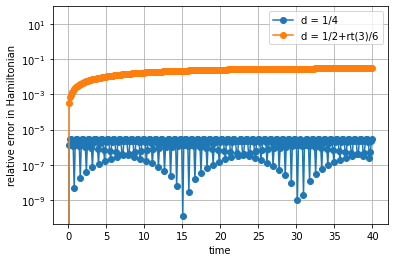

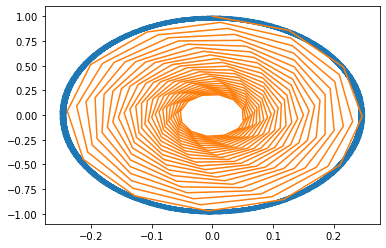

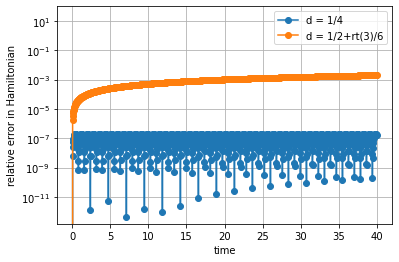

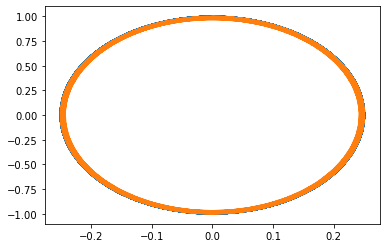

<Figure size 432x288 with 0 Axes>

In [4]:
omega0 = 4
x0 = 0.05*np.pi
p0 = 0
N0 = 500
M = 8
T = 100


from scipy.special import ellipj , ellipk
k = np.sin(x0 /2) # x0: initial condition
K = ellipk (k*k)


def f(t,y):
    return np.array([y[1], -np.sin(y[0])*(omega0**2)])


def Df(t,y):
    return np.array([[0,1],[-np.cos(y[0])*(omega0**2),0]])


def Y(t):
    sn , cn , dn , _ = ellipj (K- omega0 *t, k*k)
    x = 2* np. arcsin (k*sn)
    p = 2/ sqrt (1 -(k*sn )**2) * cn*dn * k*( - omega0 )
    return array ([x,p])




res = {}
res["d=1/4"]           = experiment(dirkQu,  f,Df,T,Y,M,N0)
res["d=1/2+rt(3)/6"]   = experiment(dirkRt,  f,Df,T,Y,M,N0)
compareErrors(res)

ham1 = testHamiltonian(1/4)


,h,DIRK 1/4-error,DIRK 1/4-eoc,DIRK 1/2+rt(3)/6-error,DIRK 1/2+rt(3)/6-eoc
0,2.0000e-01,2.601630e+00,nan,1.004820e+01,nan
1,1.0000e-01,6.420975e-01,2.019,1.177285e+01,-0.229
2,5.0000e-02,1.607761e-01,1.998,1.256500e+01,-0.094
3,2.5000e-02,4.011674e-02,2.003,9.939796e+00,0.338
4,1.2500e-02,1.002938e-02,2.000,1.349607e+00,2.881
5,6.2500e-03,2.507098e-03,2.000,1.702809e-01,2.987
6,3.1250e-03,6.267769e-04,2.000,2.130899e-02,2.998
7,1.5625e-03,1.566929e-04,2.000,2.664240e-03,3.000


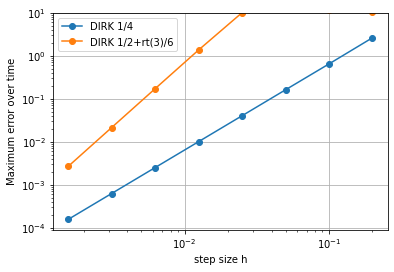

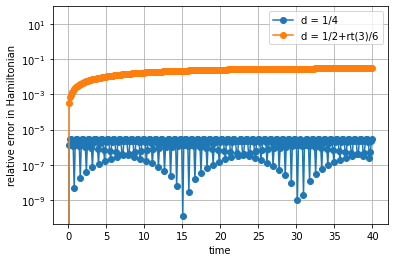

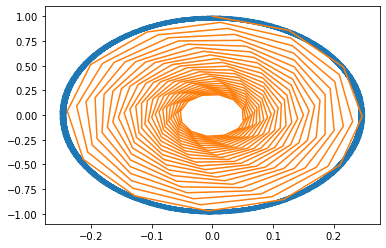

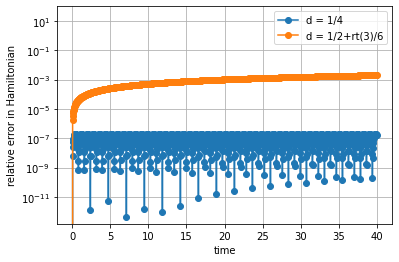

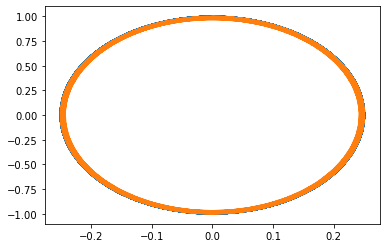

<Figure size 432x288 with 0 Axes>

In [5]:
x0 = 0.6*np.pi

from scipy.special import ellipj , ellipk
k = np.sin(x0 /2) # x0: initial condition
K = ellipk (k*k)


res = {}
res["DIRK 1/4"]           = experiment(dirkQu,  f,Df,T,Y,M,N0)
res["DIRK 1/2+rt(3)/6"]   = experiment(dirkRt,  f,Df,T,Y,M,N0)
compareErrors(res) 

ham2 = testHamiltonian((1/2)+(np.sqrt(3)/6))

I had to change the initial condition tolerance from 1e-15 to 1e-5 to allow the newton method to converge, since I had lots of errors previously at different h values.

Similarly, the EOCs converge to 2 and 3 for d=1/4 and d=1/2 + rt(3)/6 respectively which supports the theory of them having consistency orders of 2 and 3.

In Q1.3 we determined that d=1/4 maintains quadratic invariance which is a possible reason why its consistency order is 2.

The Hamiltonian phase plots shows that the results are as expected and Hamiltonian was conserved for i=1 and 3.